# Gold Market Returns

**1. Research Question:**  
Is the performance of gold prices related to which political party (Republican or Democrat) is in power?

**2. Testable Hypothesis:**  
The performance of gold, measured by changes in CPI-adjusted gold prices, differs significantly between Republican and Democratic administrations.



In [3]:
# Load necessary libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

**3.Finding Data using FRED**  
This project needs to find gold prices volatility index and an indicator of the president's party affiliation.

In [7]:
# Set up FRED data connection
# Instructions for getting your FRED API key available at these websites
# https://pypi.org/project/fredapi/ 
# http://api.stlouisfed.org/api_key.html
from fredapi import Fred
fred = Fred(api_key='c84aa59571e643b3a959e00af49adc86')

# Load CPI data for inflation calculation
temp = fred.get_series('CPIAUCSL', observation_start='1960-01-01', observation_end='2023-07-01')
df_cpi = pd.DataFrame(data = temp, columns=['CPI'])
df_cpi = df_cpi.rename_axis('Date').reset_index()

cpi_base = np.float64(df_cpi.loc[df_cpi["Date"] == "2017-12-01", "CPI"])
df_cpi['CPI_ADJ'] = cpi_base / df_cpi['CPI']
print(df_cpi.head(5))

# Load Gold Ore PPI
ppi_series = fred.get_series('PCU2122212122210', observation_start='1985-06-01', observation_end='2017-12-01')
df_ppi = pd.DataFrame(data=ppi_series, columns=['Gold_Ore_PPI'])
df_ppi = df_ppi.rename_axis('Date').reset_index()

# Merge PPI data with CPI adjustment factor
df_ppi['Date'] = pd.to_datetime(df_ppi['Date'])
df_cpi['Date'] = pd.to_datetime(df_cpi['Date'])

# Merge Data
df = pd.merge(df_ppi, df_cpi[['Date', 'CPI_ADJ']], on='Date', how='left')


# Calculate real (inflation-adjusted) PPI
df['Gold_Ore_PPI_Real'] = df['Gold_Ore_PPI'] * df['CPI_ADJ']

# Preview the first 15 rows
print(df.head(15))

/tmp/ipykernel_174/3364745427.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cpi_base = np.float64(df_cpi.loc[df_cpi["Date"] == "2017-12-01", "CPI"])


        Date    CPI   CPI_ADJ
0 1960-01-01  29.37  8.437351
1 1960-02-01  29.41  8.425876
2 1960-03-01  29.41  8.425876
3 1960-04-01  29.54  8.388795
4 1960-05-01  29.57  8.380284
         Date  Gold_Ore_PPI   CPI_ADJ  Gold_Ore_PPI_Real
0  1985-06-01         100.0  2.305163         230.516279
1  1985-07-01         100.1  2.300882         230.318296
2  1985-08-01         100.2  2.296617         230.121047
3  1985-09-01          99.2  2.292368         227.402923
4  1985-10-01          99.9  2.283917         228.163313
5  1985-11-01          99.6  2.273440         226.434661
6  1985-12-01          98.3  2.263059         222.458735
7  1986-01-01          96.9  2.254823         218.492307
8  1986-02-01         100.2  2.258933         226.345132
9  1986-03-01         102.9  2.271357         233.722589
10 1986-04-01         101.2  2.279715         230.707139
11 1986-05-01         104.4  2.273440         237.347174
12 1986-06-01         102.9  2.265128         233.081668
13 1986-07-01         

In [9]:
# 1. Load GOP flag data
import pandas as pd

url = "https://github.com/llorracc/as.180.369/blob/main/materials/presidential-term-data/GOP_flag.csv?raw=true"
df_gop = pd.read_csv(url, dtype={'Date': 'str', 'GOP': 'int64'})

# Add a day to make full date and convert to datetime
df_gop['Date'] = pd.to_datetime(df_gop['Date'] + '.01')


# 2. Merge Gold PPI with GOP flags
df = pd.merge(df, df_gop, on='Date', how='left')  # df already has Gold_Ore_PPI_Real


# 3. Calculate monthly returns (log returns) for real gold prices
import numpy as np

df['Gold_Ore_PPI_Real_Return'] = np.log(df['Gold_Ore_PPI_Real'] / df['Gold_Ore_PPI_Real'].shift(1))

# Remove the first row with NaN return
df = df.dropna(subset=['Gold_Ore_PPI_Real_Return'])

# 4. Calculate volatility (standard deviation of monthly returns) by party
volatility_by_party = df.groupby('GOP')['Gold_Ore_PPI_Real_Return'].std()
print("Gold Price Volatility (monthly, CPI-adjusted) by Party (0=Dem, 1=Rep):")
print(volatility_by_party)


# 5. Optional: preview merged dataset
print(df.head(10))
print(df.tail(10))


Gold Price Volatility (monthly, CPI-adjusted) by Party (0=Dem, 1=Rep):
GOP
0.0    0.031726
1.0    0.040440
Name: Gold_Ore_PPI_Real_Return, dtype: float64
         Date  Gold_Ore_PPI   CPI_ADJ  Gold_Ore_PPI_Real  GOP  \
1  1985-07-01         100.1  2.300882         230.318296  1.0   
2  1985-08-01         100.2  2.296617         230.121047  1.0   
3  1985-09-01          99.2  2.292368         227.402923  1.0   
4  1985-10-01          99.9  2.283917         228.163313  NaN   
5  1985-11-01          99.6  2.273440         226.434661  1.0   
6  1985-12-01          98.3  2.263059         222.458735  1.0   
7  1986-01-01          96.9  2.254823         218.492307  1.0   
8  1986-01-01          96.9  2.254823         218.492307  1.0   
9  1986-02-01         100.2  2.258933         226.345132  1.0   
10 1986-03-01         102.9  2.271357         233.722589  1.0   

    Gold_Ore_PPI_Real_Return  
1                  -0.000859  
2                  -0.000857  
3                  -0.011882  
4     

Republican average gold return: 0.0023
Democratic average gold return: -0.0019
Difference: 0.0041

Gold Price Volatility (CPI-adjusted):
Republican volatility: 0.0404
Democratic volatility: 0.0317
Difference: 0.0087


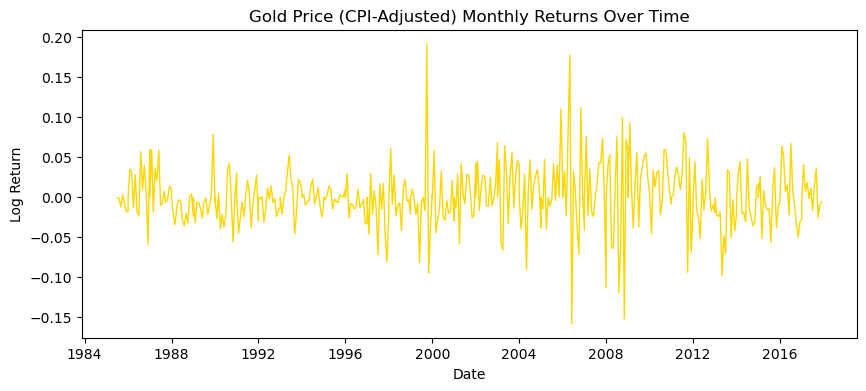

In [10]:
# Simple gold price analysis by party
import matplotlib.pyplot as plt

# Calculate average monthly return (CPI-adjusted) by party
rep_return = df[df['GOP'] == 1]['Gold_Ore_PPI_Real_Return'].mean()
dem_return = df[df['GOP'] == 0]['Gold_Ore_PPI_Real_Return'].mean()

print(f"Republican average gold return: {rep_return:.4f}")
print(f"Democratic average gold return: {dem_return:.4f}")
print(f"Difference: {rep_return - dem_return:.4f}")

# Calculate volatility (standard deviation of returns) by party
rep_volatility = df[df['GOP'] == 1]['Gold_Ore_PPI_Real_Return'].std()
dem_volatility = df[df['GOP'] == 0]['Gold_Ore_PPI_Real_Return'].std()

print("\nGold Price Volatility (CPI-adjusted):")
print(f"Republican volatility: {rep_volatility:.4f}")
print(f"Democratic volatility: {dem_volatility:.4f}")
print(f"Difference: {rep_volatility - dem_volatility:.4f}")


# Plot gold price returns over time
plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['Gold_Ore_PPI_Real_Return'], color='gold', linewidth=1)
plt.title('Gold Price (CPI-Adjusted) Monthly Returns Over Time')
plt.ylabel('Log Return')
plt.xlabel('Date')
plt.show()


In [11]:
# Descriptive volatility analysis before testing
# Calculate volatility (standard deviation) by party
rep_volatility = df[df['GOP'] == 1]['Gold_Ore_PPI_Real_Return'].std()
dem_volatility = df[df['GOP'] == 0]['Gold_Ore_PPI_Real_Return'].std()

print("Gold Price Volatility (CPI-adjusted):")
print(f"Republican volatility: {rep_volatility:.4f}")
print(f"Democratic volatility: {dem_volatility:.4f}")
print(f"Difference: {rep_volatility - dem_volatility:.4f}")

Gold Price Volatility (CPI-adjusted):
Republican volatility: 0.0404
Democratic volatility: 0.0317
Difference: 0.0087


In [12]:
from scipy.stats import ttest_ind
import numpy as np

# Drop missing values to avoid errors
df = df.dropna(subset=['Gold_Ore_PPI_Real_Return', 'GOP'])

# Split data by party
rep_returns = df[df['GOP'] == 1]['Gold_Ore_PPI_Real_Return']
dem_returns = df[df['GOP'] == 0]['Gold_Ore_PPI_Real_Return']

# Descriptive stats
print("Gold Performance by Party (CPI-adjusted returns):")
print(f"Republican average return: {np.mean(rep_returns):.4f}")
print(f"Democratic average return: {np.mean(dem_returns):.4f}")
print(f"Difference: {np.mean(rep_returns) - np.mean(dem_returns):.4f}")

# Perform Welch’s t-test (does not assume equal variances)
t_stat, p_value = ttest_ind(rep_returns, dem_returns, equal_var=False)

print("\nT-test Results:")
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p_value:.4f}")

# Interpretation helper
if p_value < 0.05:
    print("\n→ The difference in gold performance between parties is statistically significant.")
else:
    print("\n→ No statistically significant difference in gold performance between parties.")

Gold Performance by Party (CPI-adjusted returns):
Republican average return: 0.0023
Democratic average return: -0.0019
Difference: 0.0041

T-test Results:
t-statistic = 1.1246
p-value = 0.2615

→ No statistically significant difference in gold performance between parties.


**Conclusion: 
Based on the t-test results, there is no statistically significant difference in the CPI-adjusted performance of gold under Republican and Democratic administrations. This suggests that political party affiliation does not have a meaningful impact on long-term gold returns.**